## Dynamics

Dynamics | $\partial_{\tau}x_i=$ |
| :--------: | :-------: |
Biochemical | $F -B x_i - R \sum_j A_{ij} x_i x_j$ |
Epidemics | $-B x_i + R \sum_j A_{ij} (1-x_i)x_j$ |
Neuronal | $-B x_i + C \tanh x_i + R \sum_j A_{ij} \tanh x_j$ |
Population | $-B x_i^{b} + R \sum_j A_{ij} x_j^a$ |
Synchronization | $\omega_i + R \sum_j A_{ij} \sin(x_j-x_i)$ |

In [1]:
%load_ext autoreload
%autoreload 2

## Importing

In [2]:
from utils.utils import *
import optuna
from optuna.storages import JournalStorage
from optuna.storages.journal import JournalFileBackend
from experiments.experiments_gkan import ExperimentsGKAN
from experiments.experiments_mpnn import ExperimentsMPNN
from train_and_eval import eval_model

storage = JournalStorage(JournalFileBackend("optuna_journal_storage.log"))

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Symbolic reg

### Utils

In [3]:
from models.utils.MPNN import MPNN
from models.baseline.MPNN_ODE import MPNN_ODE
from train_and_eval import eval_model
from datasets.SyntheticData import SyntheticData
from sympy import symbols, sin, summation, simplify
import networkx as nx
from torch_geometric.utils import from_networkx
from utils.utils import integrate
from torch_geometric.data import Data
from models.kan.KAN import KAN
from models.GKAN_ODE import GKAN_ODE

import optuna

import warnings
warnings.filterwarnings("ignore")

In [4]:
from sympy import latex

def get_model(g, h, message_passing=True, include_time=False, atol=1e-5, rtol=1e-3, integration_method = 'scipy_solver'):
    conv = MPNN(
        g_net = g,
        h_net = h, 
        message_passing=message_passing,
        include_time=include_time
    )
    
    symb = MPNN_ODE(
        conv=conv,
        model_path="./saved_models_optuna/tmp_symb",
        adjoint=True,
        integration_method=integration_method,
        atol=atol,
        rtol=rtol
    )
    
    symb = symb.eval()
    return symb


def get_symb_test_error(g_symb, h_symb, test_set, message_passing=False, include_time=False, atol=1e-5, rtol=1e-3, scaler = None, inverse_scale=False, method='scipy_solver'):
    
    # total_len = len(dataset)
    # test_set = dataset[int(0.9*total_len):]
    
    symb = get_model(
        g=g_symb,
        h=h_symb,
        message_passing=message_passing,
        include_time=include_time,
        atol=atol,
        rtol=rtol,
        integration_method=method
    )
    
    test_loss = eval_model(
        model=symb,
        valid_data=test_set,
        criterion=torch.nn.L1Loss(),
        scaler=scaler,
        inverse_scale=inverse_scale
    )
    
    return test_loss


def get_test_set(dynamics, seed=12345, device='cuda', input_range = (0, 1), **integration_kwargs):
    graph = nx.barabasi_albert_graph(100, 3, seed=seed)
    edge_index = from_networkx(graph).edge_index
    edge_index = edge_index.to(torch.device(device))
    rng = np.random.default_rng(seed=seed)
    
    data, t = integrate(
        input_range=input_range,
        t_span = [0, 1],
        t_eval_steps=300,
        dynamics=dynamics,
        device=device,
        graph=graph,
        rng = rng,
        **integration_kwargs
    )
    
    snapshot = Data(
        x = data[0].unsqueeze(0),
        y = data[1:],
        edge_index=edge_index,
        edge_attr=None,
        t_span = t
    )
    
    return [snapshot]


def build_model_from_file(model_path, message_passing, include_time, method='dopri5', adjoint=False, pred_deriv = False):
    best_params_file = f"{model_path}/best_params.json"
    best_state_path = f"{model_path}/gkan/state_dict.pth"
    
    with open(best_params_file, 'r') as f:
        best_hyperparams = json.load(f)
    
    # g_net
    g_net = KAN(
        layers_hidden=[2, best_hyperparams['hidden_dim_g_net'], 1],
        grid_size=best_hyperparams['grid_size_g_net'],
        spline_order=best_hyperparams['spline_order_g_net'],
        grid_range=[-best_hyperparams['range_limit_g_net'], best_hyperparams['range_limit_g_net']],
        mu_1=best_hyperparams['mu_1_g_net'],
        mu_2=best_hyperparams['mu_2_g_net'],
        device='cuda'
    )
    
    time_dim = 1 if include_time else 0
    in_dim_h = 2 if message_passing else 1
    in_dim_h += time_dim
    
    # h_net
    h_net = KAN(
        layers_hidden=[in_dim_h, best_hyperparams['hidden_dim_h_net'], 1],
        grid_size=best_hyperparams['grid_size_h_net'],
        spline_order=best_hyperparams['spline_order_h_net'],
        grid_range=[-best_hyperparams['range_limit_h_net'], best_hyperparams['range_limit_h_net']],
        mu_1=best_hyperparams['mu_1_h_net'],
        mu_2=best_hyperparams['mu_2_h_net'],
        device='cuda'
    )
    
    gkan = MPNN(
        h_net=h_net,
        g_net=g_net,
        message_passing=message_passing,
        include_time=include_time,
        neg=pred_deriv
    )
    
    model = GKAN_ODE(
        conv=gkan,
        model_path='./saved_models_optuna/tmp',
        lmbd_g=best_hyperparams['lamb_g_net'],
        lmbd_h=best_hyperparams['lamb_h_net'],
        integration_method=method,
        adjoint=adjoint
    )
    
    model = model.to(torch.device('cuda'))
    model.load_state_dict(torch.load(best_state_path, weights_only=False, map_location=torch.device('cuda')))
    
    return model


def post_process_gkan(
    g_symb, 
    h_symb, 
    model_path, 
    test_set, 
    message_passing=False, 
    include_time=False,
    atol=1e-5,
    rtol=1e-3,
    method='dopri5',
    scaler=None,
    inverse_scale=False,
    adjoint=True
):
    test_loss_symb = get_symb_test_error(
        g_symb=g_symb,
        h_symb=h_symb,
        test_set=test_set,
        message_passing=True,
        include_time=include_time,
        atol=atol,
        rtol=rtol,
        method=method,
        scaler=scaler,
        inverse_scale=inverse_scale
    )
    
    print(f"Test loss of symbolic formula: {test_loss_symb}")
    
    # Loading best model
    best_model = build_model_from_file(
        model_path=model_path,
        message_passing=message_passing,
        include_time=include_time,
        method=method,
        adjoint=adjoint
    )
    
    tot_params = sum(p.numel() for p in best_model.parameters() if p.requires_grad)
    print(f"Number of model's parameters: {tot_params}")
    
    best_model = best_model.eval()
    test_loss_model = get_symb_test_error(
        g_symb=best_model.conv.model.g_net,
        h_symb=best_model.conv.model.h_net,
        test_set=test_set,
        message_passing=message_passing,
        include_time=include_time,
        atol=atol,
        rtol=rtol,
        method=method,
        scaler=scaler,
        inverse_scale=inverse_scale
    )
    
    print(f"Test loss best model: {test_loss_model}")

    y_true = test_set[0].y.detach().cpu().numpy()
    y_pred = best_model(snapshot = test_set[0]).detach().cpu().numpy()
    
    return y_true, y_pred


def get_error_spline_wise(model_path, test_set, theta=0.1, atol=1e-5, rtol=1e-3):
    symb_spline_wise = fit_model(
        n_h_hidden_layers=2,
        n_g_hidden_layers=2,
        model_path=model_path,
        theta=theta,
        message_passing=False,
        include_time=False     
    )
    
    # print(latex(quantise(symb_spline_wise)))
    
    g_symb = automatic_fix_symbolic_kan(
    symb_functions_file=f"{model_path}/g_net/symb_functions.json",
    in_dim=2
    )

    h_symb = automatic_fix_symbolic_kan(
        symb_functions_file=f"{model_path}/h_net/symb_functions.json",
        in_dim=1
    )
    

    test_loss_splinewise = get_symb_test_error(
        g_symb=g_symb,
        h_symb=h_symb,
        test_set=test_set,
        message_passing=False,
        include_time=False,
        method="dopri5",
        atol=atol,
        rtol=rtol
    )
    
    symb_model = get_model(
        g=g_symb,
        h=h_symb,
        message_passing=False,
        include_time=False,
        atol=atol,
        rtol=rtol,
        integration_method="dopri5"
    )
    
    y_true = test_set[0].y.detach().cpu().numpy()
    y_pred = symb_model(snapshot = test_set[0]).detach().cpu().numpy()
    
    return quantise(symb_spline_wise), test_loss_splinewise, y_true, y_pred


def plot_predictions(y_true, y_pred, node_index = 0):
    plt.figure(figsize=(16, 8))
    plt.plot(y_true[:, node_index, :], label='y_true', marker='o')
    plt.plot(y_pred[:, node_index, :], label='y_pred', marker='o')
    plt.xlabel('Time step')
    plt.ylabel('Value')
    plt.title(f'y_true vs y_pred for Node {node_index}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

def valid_symb_model(valid_set, model_path_gkan, test_set, n_trials=50):
    valid_set = valid_set
    alpha_range = [1e-5, 0.1]
    theta_range = [1e-5, 0.5]
    
    def objective(trial):
        theta = trial.suggest_float('theta', theta_range[0], theta_range[1], log=True)
        alpha = trial.suggest_float('alpha', alpha_range[0], alpha_range[1], log=True)
        _, val_loss = get_error_spline_wise(
            model_path=model_path_gkan,
            test_set=valid_set,
            theta=theta,
            use_sindy=False,
            alpha = alpha
        )   
        return val_loss
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)
    
    best_theta, best_alpha = study.best_params['theta'], study.best_params['alpha']
    expr, test_loss = get_error_spline_wise(
            model_path=model_path_gkan,
            test_set=test_set,
            theta=best_theta,
            use_sindy=False,
            alpha=best_alpha
    )
    
    print(f"Test error: {test_loss}")
    
    return expr

### LB losses


#### Kuramoto

In [5]:
kur_config = load_config("./configs/config_ic1/config_kuramoto.yml")

KUR = get_test_set(
    dynamics=kur_config['name'],
    seed = 12345,
    device=kur_config['device'],
    input_range=kur_config['input_range'],
    **kur_config['integration_kwargs']    
)

g_symb = lambda x: torch.sin(x[:, 1] - x[:, 0]).unsqueeze(-1)
h_symb = lambda x: 2.0 + 0.5 * x[:, 1].unsqueeze(-1)

test_loss = get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=KUR,
    message_passing=True,
    include_time=False,
    atol=1e-5,
    rtol=1e-3
)

print(f"Kuramoto: {test_loss}")


Kuramoto: 7.774222467560321e-05


#### Epidemics

In [6]:
epid_config = load_config("./configs/config_ic1/config_epidemics.yml")

EPID = get_test_set(
    dynamics=epid_config['name'],
    seed = 12345,
    device=epid_config['device'],
    input_range=epid_config['input_range'],
    **epid_config['integration_kwargs']    
)

g_symb = lambda x: 0.5*x[:, 1].unsqueeze(-1) * (1 - x[:, 0].unsqueeze(-1))
h_symb = lambda x: x[:, 1].unsqueeze(1) - 0.5 * x[:, 0].unsqueeze(-1)

test_loss = get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=EPID,
    message_passing=True,
    include_time=False,
    atol=1e-5,
    rtol=1e-3
)

print(f"Epidemics: {test_loss}")


Epidemics: 1.2375590813462622e-05


#### Population

In [7]:
pop_config = load_config("./configs/config_ic1/config_population.yml")

POP = get_test_set(
    dynamics=pop_config['name'],
    seed = 12345,
    device=pop_config['device'],
    input_range=pop_config['input_range'],
    **pop_config['integration_kwargs']    
)

g_symb = lambda x: 0.2*torch.square(x[:, 1].unsqueeze(-1))
h_symb = lambda x: -0.5 * torch.square(x[:, 0].unsqueeze(-1)) + x[:, 1].unsqueeze(1) 

test_loss = get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=POP,
    message_passing=True,
    include_time=False,
    atol=1e-5,
    rtol=1e-3
)

print(f"Population: {test_loss}")


Population: 1.5756202628836036e-05


#### Neuronal

In [8]:
neur_config = load_config("./configs/config_ic1/config_neuronal.yml")

NEUR = get_test_set(
    dynamics=neur_config['name'],
    seed = 12345,
    device=neur_config['device'],
    input_range=neur_config['input_range'],
    **neur_config['integration_kwargs']    
)

g_symb = lambda x: 0.3*torch.tanh(x[:, 1].unsqueeze(-1))
h_symb = lambda x: -0.5 * x[:, 0].unsqueeze(-1) + 0.8*torch.tanh(x[:, 0].unsqueeze(-1)) + x[:, 1].unsqueeze(-1) 

test_loss = get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=NEUR,
    message_passing=True,
    include_time=False,
    atol=1e-5,
    rtol=1e-3
)

print(f"Neuronal: {test_loss}")

Neuronal: 1.1294792784610763e-05


#### Biochemical

In [9]:
bio_config = load_config("./configs/config_ic1/config_biochemical.yml")

BIO = get_test_set(
    dynamics=bio_config['name'],
    seed = 12345,
    device=bio_config['device'],
    input_range=bio_config['input_range'],
    **bio_config['integration_kwargs']    
)

g_symb = lambda x: (-0.5*x[:, 1] * x[:, 0]).unsqueeze(-1)
h_symb = lambda x: (1.0 - 0.5 * x[:, 0]).unsqueeze(-1)  + x[:, 1].unsqueeze(-1) 

test_loss = get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=BIO,
    message_passing=True,
    include_time=False,
    atol=1e-5,
    rtol=1e-3
)

print(f"Biochemical: {test_loss}")

Biochemical: 5.44711383554386e-06


### Kuramoto GKAN

#### IC=1

In [61]:
model_path_gkan = './saved_models/gkan/model_kuramoto_gkan/kuramoto_gkan_ic1_s5/2/gkan'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [62]:
gkan_symb

\sum_{j}( -0.50182724*sin(x_i - x_j)) + 0.014933765*log(x_i) + 1.9816756

In [63]:
g_symb = lambda x: torch.sin(x[:, 0] - x[:, 1]).unsqueeze(-1)
h_symb = lambda x: 1.9816756 - 0.50182724*x[:, 1].unsqueeze(-1) + 0.014933765 * torch.log(x[:, 0].unsqueeze(-1))

y_true, y_pred = post_process_gkan(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/gkan/model_kuramoto_gkan/kuramoto_gkan_ic1_s5/2',
    test_set=KUR,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.005671596620231867
Number of model's parameters: 112
Test loss best model: 0.022857245057821274


In [9]:
model_path_gkan = './saved_models/gkan/model_kuramoto_gkan/kuramoto_gkan_ic1_s5/2/gkan'

get_error_spline_wise(
    model_path=model_path_gkan,
    test_set=KUR,
    theta=0.01
)

Pruning node (0,1)


/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_

Test error: 0.073582723736763


\sum_{j}(0.5*sin(1.0*x_i - 1.0*x_j + 3.14) - 0.02) + 0.06*x_i + 0.53*(0.16*x_i - 1)**2 + 1.64

#### IC=3

In [13]:
model_path_gkan = './saved_models/gkan/model_kuramoto_gkan/kuramoto_gkan_ic3_s5/2/gkan'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [14]:
gkan_symb

\sum_{j}( -0.500627060424535*sin(x_i - x_j)) + 2.0001128 - 0.0017052613/x_i

In [15]:
quantise(gkan_symb)

\sum_{j}(-0.5*sin(x_i - x_j)) + 2.0

In [16]:
g_symb = lambda x: torch.sin(x[:, 0] - x[:, 1]).unsqueeze(-1)
h_symb = lambda x: 2.0001128 - 0.500627060424535 * x[:, 1].unsqueeze(-1) - (0.0017052613 / x[:, 0].unsqueeze(-1))


y_true, y_pred = post_process_gkan(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/gkan/model_kuramoto_gkan/kuramoto_gkan_ic3_s5/2',
    test_set=KUR,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.0013975442852824926
Number of model's parameters: 130
Test loss best model: 0.0036783141549676657


In [10]:
model_path_gkan = "saved_models/gkan/model_kuramoto_gkan/kuramoto_gkan_ic3_s5/2/gkan"

get_error_spline_wise(
    model_path=model_path_gkan,
    test_set=KUR,
    theta=0.01
)

Pruning node (0,0)


/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_

Test error: 0.47688260674476624


/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')


\sum_{j}(0.16 - 0.5*sin(1.0*x_i - 1.0*x_j)) + 2.0

#### IC=5

In [17]:
model_path_gkan = './saved_models/gkan/model_kuramoto_gkan/kuramoto_gkan_ic5_s5/0/gkan'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [18]:
gkan_symb

\sum_{j}( -0.5006555*sin(x_i - x_j)) - 0.00024808984*x_i + 2.001539

In [19]:
quantise(gkan_symb)

\sum_{j}(-0.5*sin(x_i - x_j)) + 2.0

In [20]:
g_symb = lambda x: torch.sin(x[:, 0] - x[:, 1]).unsqueeze(-1)
h_symb = lambda x: 2.001539 - 0.5006555 * x[:, 1].unsqueeze(-1) - (0.00024808984 * x[:, 0].unsqueeze(-1))


y_true, y_pred = post_process_gkan(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/gkan/model_kuramoto_gkan/kuramoto_gkan_ic5_s5/0',
    test_set=KUR,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.001474372809752822
Number of model's parameters: 114
Test loss best model: 0.0050172205083072186


In [11]:
model_path_gkan = './saved_models/gkan/model_kuramoto_gkan/kuramoto_gkan_ic5_s5/0/gkan'

spline_wise, error, y_true, y_pred = get_error_spline_wise(
    model_path = model_path_gkan,
    test_set=KUR,
    theta=0.01
)

Pruning node (0,1)


In [12]:
spline_wise

\sum_{j}(-0.5*sin(1.0*x_i - 1.0*x_j)) + 2.0

In [13]:
print(f"Test error: {error}")

Test error: 0.002658226527273655


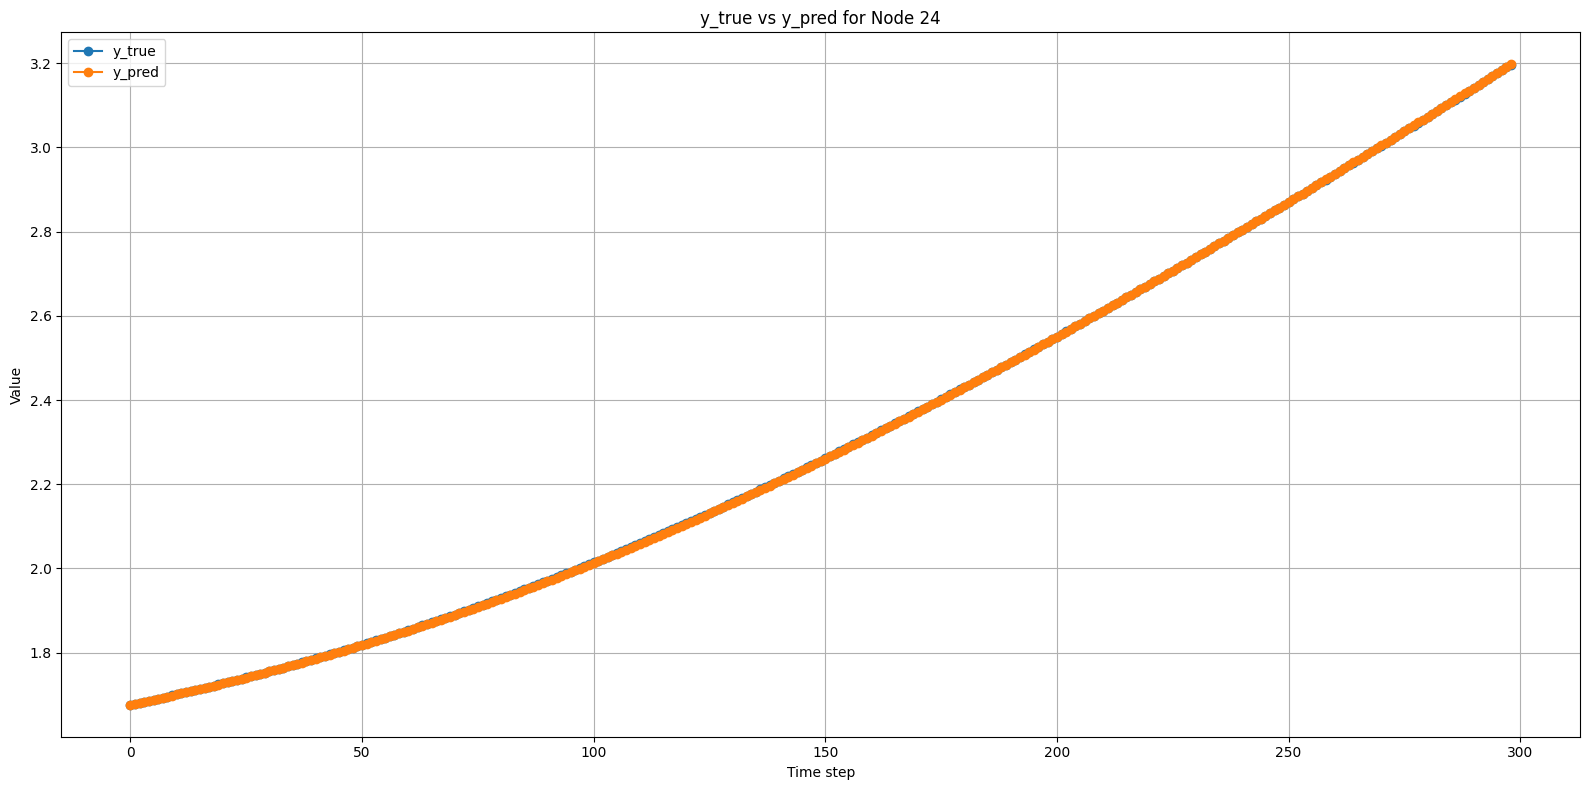

In [22]:
plot_predictions(y_true, y_pred, node_index=24)

In [ ]:
model_path_gkan = './saved_models/gkan/model_kuramoto_gkan/kuramoto_gkan_ic5_s5/0/gkan'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

hierarchical_symb_fitting(
    model_path=model_path_gkan,
    theta=0.1,
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    pysr_model=pysr_model,    
    sample_size=10000,
    message_passing=False,
    include_time=False,
    neuron_level=True
)

Pruning node (0,1)


In [10]:
model_path_gkan = './saved_models/gkan/model_kuramoto_gkan/kuramoto_gkan_ic5_s5/0/gkan'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=100
)

hierarchical_symb_fitting(
    model_path=model_path_gkan,
    theta=0.1,
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    pysr_model=pysr_model,    
    sample_size=10000,
    message_passing=False,
    include_time=False,
    neuron_level=False
)

Pruning node (0,1)


### Epidemics GKAN

#### IC=1

In [9]:
model_path_gkan = './saved_models/gkan/model_epidemics_gkan/epidemics_gkan_ic1_s5/0/gkan'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [10]:
gkan_symb

\sum_{j}( -0.42873818*x_j*tanh(log(x_i))) - 0.49842733*x_i

In [11]:
quantise(gkan_symb)

\sum_{j}(-0.43*x_j*tanh(log(x_i))) - 0.5*x_i

In [35]:
g_symb = lambda x: -0.42873818*x[:, 1].unsqueeze(-1) * torch.tanh(torch.log(x[:, 0].unsqueeze(-1)))
h_symb = lambda x: x[:, 1].unsqueeze(-1) - 0.49842733 * x[:, 0].unsqueeze(-1)

y_true, y_pred = post_process_gkan(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/gkan/model_epidemics_gkan/epidemics_gkan_ic1_s5/0',
    test_set=EPID,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.00414850702509284
Number of model's parameters: 186
Test loss best model: 0.00031669693998992443


In [17]:
model_path_gkan = './saved_models/gkan/model_epidemics_gkan/epidemics_gkan_ic1_s5/0/gkan'

get_error_spline_wise(
    model_path=model_path_gkan,
    test_set=EPID,
    theta=0.1
)

/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_

Pruning node (0,1)


/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_

Test error: 0.01297961175441742


\sum_{j}(-0.01*x_i + 0.18*x_j + 0.19*(-x_i + 0.7*x_j + 0.62)**2 + 0.8*sin(0.63*x_i + 0.48*x_j + 1.15) - 0.8) - 0.48*x_i + 0.03

#### IC=3

In [15]:
model_path_gkan = './saved_models/gkan/model_epidemics_gkan/epidemics_gkan_ic3_s5/1/gkan'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [17]:
gkan_symb

\sum_{j}( 0.500189*x_j*(0.9999729 - x_i)) - 0.500137812974365*x_i

In [18]:
quantise(gkan_symb)

\sum_{j}(0.5*x_j*(1.0 - x_i)) - 0.5*x_i

In [41]:
g_symb = lambda x: 0.5001888*x[:, 1].unsqueeze(-1) * (0.999973 - x[:, 0].unsqueeze(-1))
h_symb = lambda x: x[:, 1].unsqueeze(-1) - 0.500137812974365 * x[:, 0].unsqueeze(-1)

y_true, y_pred = post_process_gkan(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/gkan/model_epidemics_gkan/epidemics_gkan_ic3_s5/1',
    test_set=EPID,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 6.870869401609525e-05
Number of model's parameters: 142
Test loss best model: 0.00019070653070230037


In [18]:
model_path_gkan = './saved_models/gkan/model_epidemics_gkan/epidemics_gkan_ic3_s5/1/gkan'

get_error_spline_wise(
    model_path=model_path_gkan,
    test_set=EPID,
    theta=0.1
)

/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_

Test error: 0.005588100291788578


\sum_{j}(0.03*x_i + 0.12*x_j + 0.26*(-x_i + 0.62*x_j + 0.71)**2 - 0.15*sin(1.27*x_i + 1.12*x_j - 2.52) - 0.17) + 0.14*(0.65*x_i - 1)**2 - 0.17*(x_i + 0.54)**2 - 0.13

#### IC=5

In [19]:
model_path_gkan = './saved_models/gkan/model_epidemics_gkan/epidemics_gkan_ic5_s5/2/gkan'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [20]:
gkan_symb

\sum_{j}( x_j*(0.49999106 - 0.4999124*x_i)) - 0.5005673*x_i

In [21]:
quantise(gkan_symb)

\sum_{j}(x_j*(0.5 - 0.5*x_i)) - 0.5*x_i

In [37]:
g_symb = lambda x: x[:, 1].unsqueeze(-1) * (0.49999106 - 0.4999124 *x[:, 0].unsqueeze(-1))
h_symb = lambda x: x[:, 1].unsqueeze(-1) - 0.5005673 * x[:, 0].unsqueeze(-1)

y_true, y_pred = post_process_gkan(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/gkan/model_epidemics_gkan/epidemics_gkan_ic5_s5/2',
    test_set=EPID,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 9.24893029150553e-05
Number of model's parameters: 165
Test loss best model: 0.00031030617537908256


In [14]:
model_path_gkan = './saved_models/gkan/model_epidemics_gkan/epidemics_gkan_ic5_s5/2/gkan'

spline_wise, error, y_true, y_pred = get_error_spline_wise(
    model_path=model_path_gkan,
    test_set=EPID,
    theta=0.1
)

Pruning node (0,0)


In [15]:
spline_wise

\sum_{j}(-0.12*x_i - 0.13*x_j**2 + 0.28*x_j + 0.21*(-x_i + 0.96*x_j + 0.23)**2 + 0.11*cos(1.16*x_i + 0.14) - 0.05) - 0.51*x_i

In [25]:
latex(spline_wise)

'\\sum_{j}(-0.12*x_i - 0.13*x_j**2 + 0.28*x_j + 0.21*(-x_i + 0.96*x_j + 0.23)**2 + 0.11*cos(1.16*x_i + 0.14) - 0.05) - 0.51 x_{i}'

In [26]:
print(f"Test error: {error}")

Test error: 0.05213296413421631


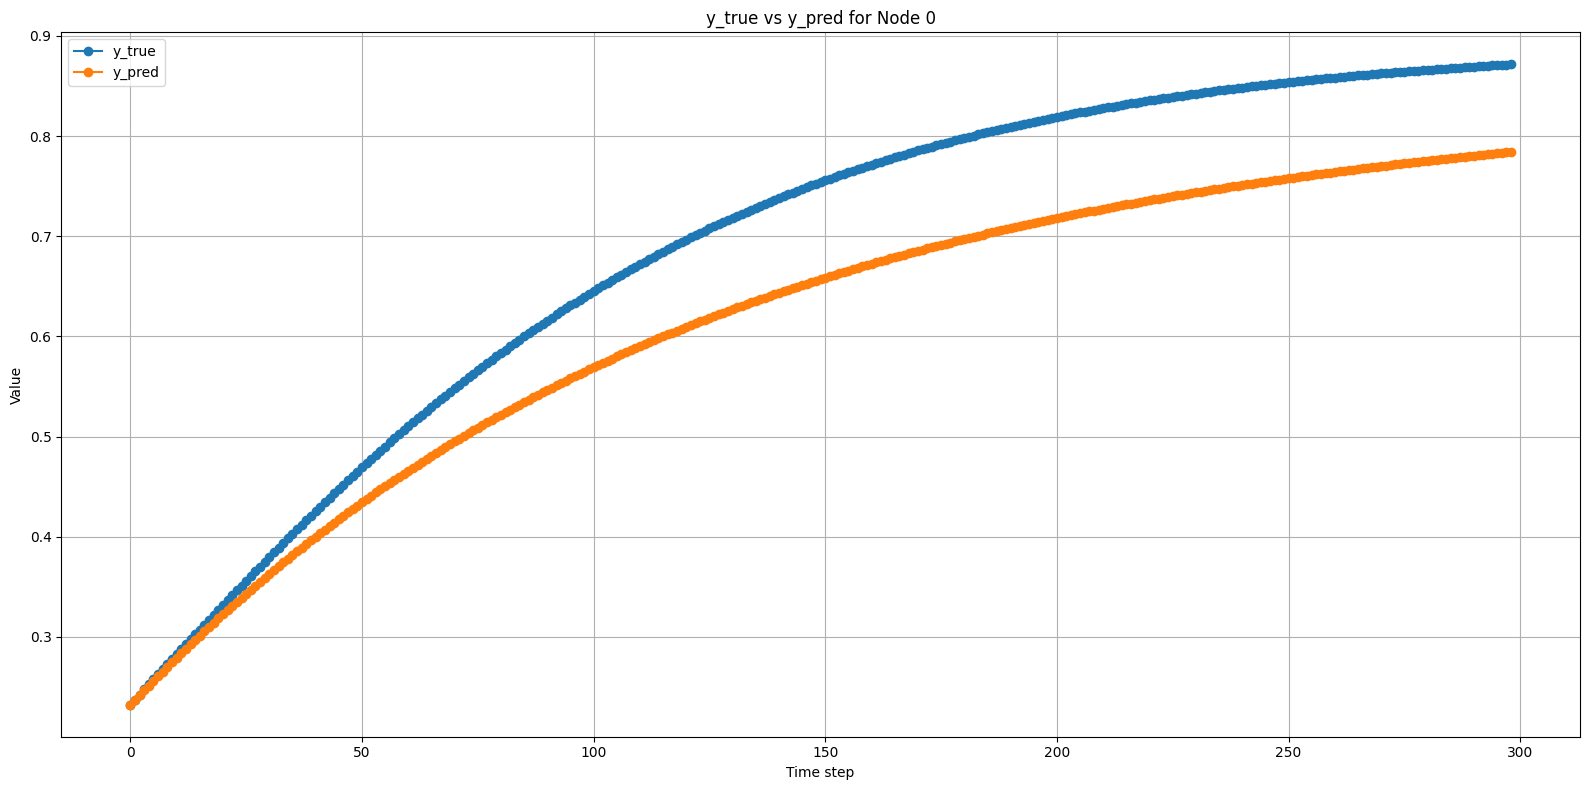

In [27]:
plot_predictions(y_true, y_pred, node_index=0)

In [5]:
model_path_gkan = './saved_models/gkan/model_epidemics_gkan/epidemics_gkan_ic5_s5/2/gkan'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

hierarchical_symb_fitting(
    model_path=model_path_gkan,
    theta=-np.inf,
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    pysr_model=pysr_model,    
    sample_size=10000,
    message_passing=False,
    include_time=False,
    neuron_level=True
)

In [11]:
model_path_gkan = './saved_models/gkan/model_epidemics_gkan/epidemics_gkan_ic5_s5/2/gkan'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

hierarchical_symb_fitting(
    model_path=model_path_gkan,
    theta=-np.inf,
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    pysr_model=pysr_model,    
    sample_size=10000,
    message_passing=False,
    include_time=False,
    neuron_level=False
)

### Neuronal GKAN

#### IC=1

In [52]:
model_path_gkan = "./saved_models/gkan/model_neuronal_gkan/neuronal_gkan_ic1_s5/1/gkan"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=300
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [53]:
gkan_symb

\sum_{j}( 0.29587078*tanh(x_j)) + tanh(1.9334015/x_i) - 0.8728571

In [54]:
quantise(gkan_symb)

\sum_{j}(0.3*tanh(x_j)) + tanh(1.93/x_i) - 0.87

In [38]:
g_symb = lambda x: 0.29587078 * torch.tanh(x[:, 1].unsqueeze(-1))
h_symb = lambda x: x[:, 1].unsqueeze(-1) + torch.tanh(1.9334015/x[:, 0].unsqueeze(-1)) - 0.8728571

y_true, y_pred = post_process_gkan(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/gkan/model_neuronal_gkan/neuronal_gkan_ic1_s5/1',
    test_set=NEUR,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.01227455586194992
Number of model's parameters: 108
Test loss best model: 0.0014574796659871936


In [28]:
model_path_gkan = "./saved_models/gkan/model_neuronal_gkan/neuronal_gkan_ic1_s5/1/gkan"

spline_wise = get_error_spline_wise(
    model_path=model_path_gkan,
    test_set=NEUR,
    theta=0.01
)

/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_

Test error: 0.014304430224001408


In [29]:
spline_wise

\sum_{j}(-64.1*(0.99*tanh(0.55*x_j + 1.92) - 1)**2 - 0.12*(0.1*x_i - 0.4*x_j + 1)**2 + 0.31) + 0.24*sin(1.5*x_i + 0.53) - 0.1

#### IC=3

In [55]:
model_path_gkan = "./saved_models/gkan/model_neuronal_gkan/neuronal_gkan_ic3_s5/1/gkan"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [56]:
gkan_symb

\sum_{j}( 0.29789564*tanh(x_j)) - 1.6103699*log(x_i + 1) + 1.6103699*tanh(x_i)

In [4]:
quantise(gkan_symb)

\sum_{j}(0.3*tanh(x_j)) - 0.63*x_i + log(x_i + 1)

In [39]:
g_symb = lambda x: 0.29789564 * torch.tanh(x[:, 1].unsqueeze(-1))
h_symb = lambda x: x[:, 1].unsqueeze(-1) - 1.6103699 * torch.log(x[:, 0].unsqueeze(-1) + 1) + 1.6103699 * torch.tanh(x[:, 0].unsqueeze(-1))

y_true, y_pred = post_process_gkan(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/gkan/model_neuronal_gkan/neuronal_gkan_ic3_s5/1',
    test_set=NEUR,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.0134543776512146
Number of model's parameters: 201
Test loss best model: 0.0003793847281485796


In [31]:
model_path_gkan = "./saved_models/gkan/model_neuronal_gkan/neuronal_gkan_ic3_s5/1/gkan"


get_error_spline_wise(
    model_path=model_path_gkan,
    test_set=NEUR,
    theta=0.01
)

/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_

Test error: 0.04016033187508583


\sum_{j}(0.01*(0.12*x_j - 0.09*(0.87*x_i - 1)**2 + 1)**2 + 0.09*tanh(-0.14*x_i + 0.7*x_j + 0.09) + 0.1*tanh(0.9*x_j + 0.25*Abs(1.24*x_i - 0.88) - 0.29) + 0.1) - 0.2*(0.38*x_i + 1)**2 - 0.03*sin(0.91*x_i - 2.73) - 0.06*sin(1.16*x_i - 3.15) + 0.37

#### IC=5

In [57]:
model_path_gkan = "./saved_models/gkan/model_neuronal_gkan/neuronal_gkan_ic5_s5/2/gkan"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [58]:
gkan_symb

\sum_{j}( 0.2982709*tanh(x_j)) - 0.49681002*x_i + tanh(log(x_i + 1))

In [40]:
g_symb = lambda x: 0.2982709 * torch.tanh(x[:, 1].unsqueeze(-1))
h_symb = lambda x: x[:, 1].unsqueeze(-1) - 0.49681002 * x[:, 0].unsqueeze(-1) + torch.tanh(torch.log(x[:, 0].unsqueeze(-1) + 1))

y_true, y_pred = post_process_gkan(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/gkan/model_neuronal_gkan/neuronal_gkan_ic5_s5/2',
    test_set=NEUR,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.004336248617619276
Number of model's parameters: 94
Test loss best model: 0.00023901843815110624


In [9]:
model_path_gkan = "./saved_models/gkan/model_neuronal_gkan/neuronal_gkan_ic5_s5/2/gkan"

spline_wise, error, y_true, y_pred = get_error_spline_wise(
    model_path=model_path_gkan,
    test_set=NEUR,
    theta=0.1
)

In [10]:
spline_wise

\sum_{j}(0.03*x_j + 0.01*cos(0.69*x_i - 0.67) + 0.21) + 0.7*cos(8.02*tanh(0.12*x_i + 0.29) - 2.84) - 0.58

In [11]:
print(f"Test error: {error}")

Test error: 0.018507104367017746


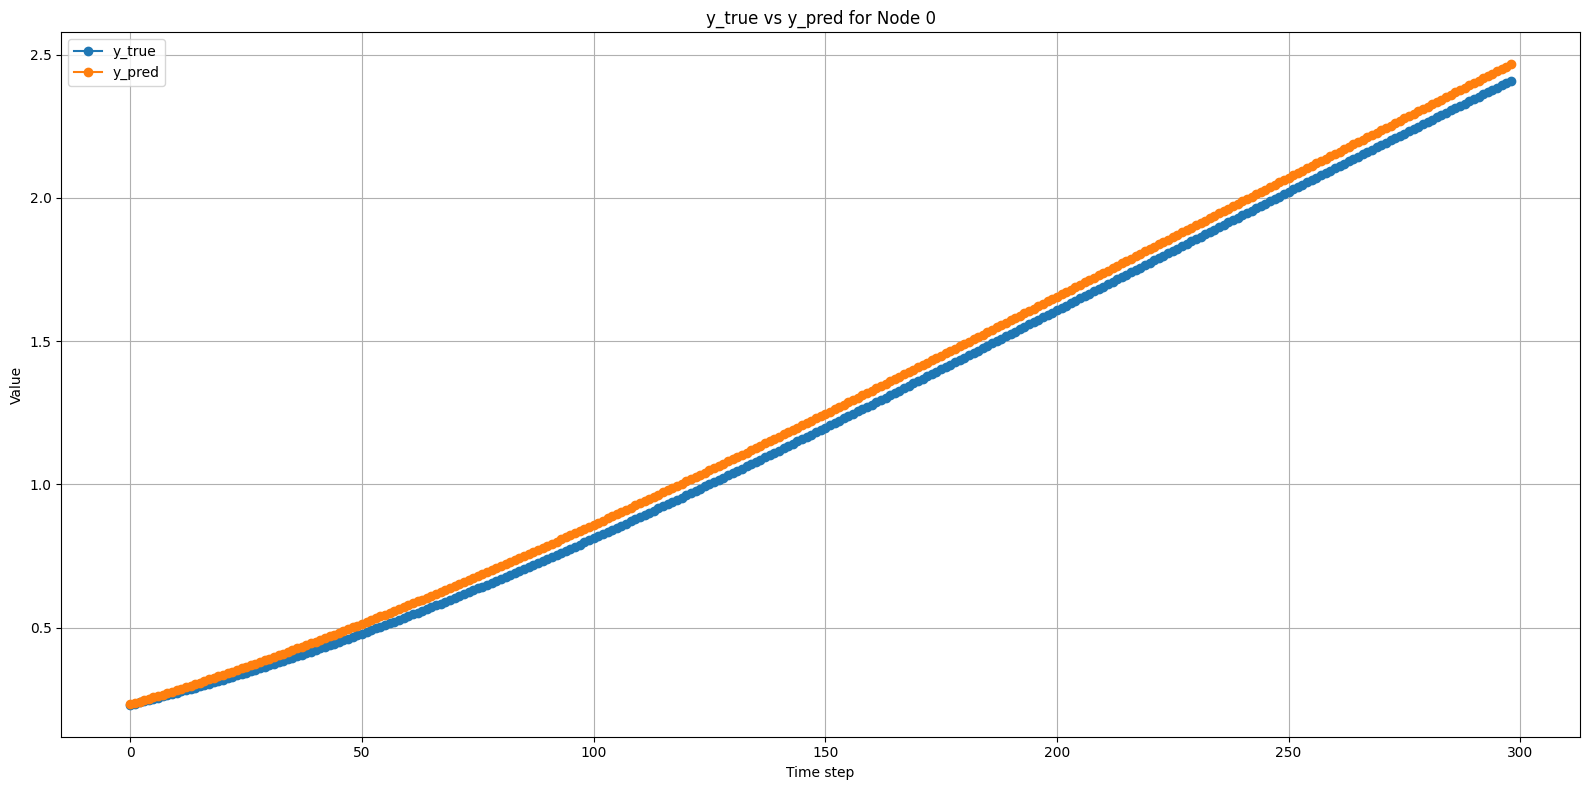

In [12]:
plot_predictions(y_true, y_pred, node_index=0)

In [9]:
model_path_gkan = "./saved_models/gkan/model_neuronal_gkan/neuronal_gkan_ic5_s5/2/gkan"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

hierarchical_symb_fitting(
    model_path=model_path_gkan,
    theta=-np.inf,
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    pysr_model=pysr_model,    
    sample_size=10000,
    message_passing=False,
    include_time=False,
    neuron_level=True
)

### Biochemical GKAN

#### IC=3


In [22]:
model_path_gkan = './saved_models/gkan/model_biochemical_gkan/biochemical_gkan_ic3_s5/1/gkan'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [23]:
gkan_symb

\sum_{j}( -0.50004584*x_i*x_j) - 0.5002544*x_i + 1.0001771

In [24]:
quantise(gkan_symb)

\sum_{j}(-0.5*x_i*x_j) - 0.5*x_i + 1.0

In [25]:
g_symb = lambda x: (-0.50004584*x[:, 1] * x[:, 0]).unsqueeze(-1)
h_symb = lambda x: -0.5002544 * x[:, 0].unsqueeze(-1) + x[:, 1].unsqueeze(-1) + 1.0001771

y_true, y_pred = post_process_gkan(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/gkan/model_biochemical_gkan/biochemical_gkan_ic3_s5/1',
    test_set=BIO,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 3.3167380024679005e-05
Number of model's parameters: 130
Test loss best model: 6.272672180784866e-05


In [23]:
model_path_gkan = './saved_models/gkan/model_biochemical_gkan/biochemical_gkan_ic3_s5/1/gkan'

spline_wise, error = get_error_spline_wise(
    model_path=model_path_gkan,
    test_set=BIO,
    theta=0.1
)

Pruning node (0,0)


In [24]:
spline_wise

\sum_{j}(-0.39*tanh(0.84*tan(0.29*x_i - 1.3) + 0.93*tan(0.41*x_j - 1.26) + 2.54) - 0.41) - 0.5*x_i + 1.0

In [25]:
print(f"Test error: {error}")

Test error: 0.012646624818444252


#### IC = 1

In [26]:
model_path_gkan = "./saved_models/gkan/model_biochemical_gkan/biochemical_gkan_ic1_s5/0/gkan"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [27]:
gkan_symb

\sum_{j}( -0.50047237*x_i*x_j) - sin(tanh(x_i) + 4.9726315)

In [28]:
quantise(gkan_symb)

\sum_{j}(-0.5*x_i*x_j) - sin(tanh(x_i) + 4.97)

In [30]:
g_symb = lambda x: (-0.50047237*x[:, 1] * x[:, 0]).unsqueeze(-1)
h_symb = lambda x: -torch.sin(torch.tanh(x[:, 0].unsqueeze(-1)) + 4.9726315) + x[:, 1].unsqueeze(-1)

y_true, y_pred = post_process_gkan(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/gkan/model_biochemical_gkan/biochemical_gkan_ic1_s5/0',
    test_set=BIO,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.0005947164027020335
Number of model's parameters: 134
Test loss best model: 0.0003512927796691656


In [9]:
model_path_gkan = "./saved_models/gkan/model_biochemical_gkan/biochemical_gkan_ic1_s5/0/gkan"

get_error_spline_wise(
    model_path=model_path_gkan,
    test_set=BIO,
    theta=0.1
)

/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_

Test error: 0.010756343603134155


\sum_{j}(-0.16*x_i**2 - 0.47*x_i*x_j + 0.14*x_i - 0.14*x_j**2 + 0.12*x_j - 0.04) - 0.48*x_i + 0.99

#### IC=5

In [31]:
model_path_gkan = "./saved_models/gkan/model_biochemical_gkan/biochemical_gkan_ic5_s5/0/gkan"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [32]:
gkan_symb

\sum_{j}( -0.49992257*x_i*x_j) - 0.49867707*x_i + 0.9993234

In [33]:
quantise(gkan_symb)

\sum_{j}(-0.5*x_i*x_j) - 0.5*x_i + 1.0

In [34]:
g_symb = lambda x: (-0.49992257*x[:, 1] * x[:, 0]).unsqueeze(-1)
h_symb = lambda x: -0.49867707 * x[:, 0].unsqueeze(-1) + x[:, 1].unsqueeze(-1) + 0.9993234

y_true, y_pred = post_process_gkan(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/gkan/model_biochemical_gkan/biochemical_gkan_ic5_s5/0',
    test_set=BIO,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 8.401498780585825e-05
Number of model's parameters: 187
Test loss best model: 0.00015913214883767068


In [15]:
model_path_gkan = "./saved_models/gkan/model_biochemical_gkan/biochemical_gkan_ic5_s5/1/gkan"

spline_wise, error, y_true, y_pred = get_error_spline_wise(
    model_path=model_path_gkan,
    test_set=BIO,
    theta=-np.inf
)

In [16]:
spline_wise

\sum_{j}(-0.14*x_i - 0.15*x_j - 0.09*(x_i + 0.83*x_j - 0.29)**2 - 3.78*cos(0.26*x_i - 0.26*x_j) + 3.83) - 0.5*x_i + 1.0

In [30]:
print(f"Test error: {error}")

Test error: 0.006680850870907307


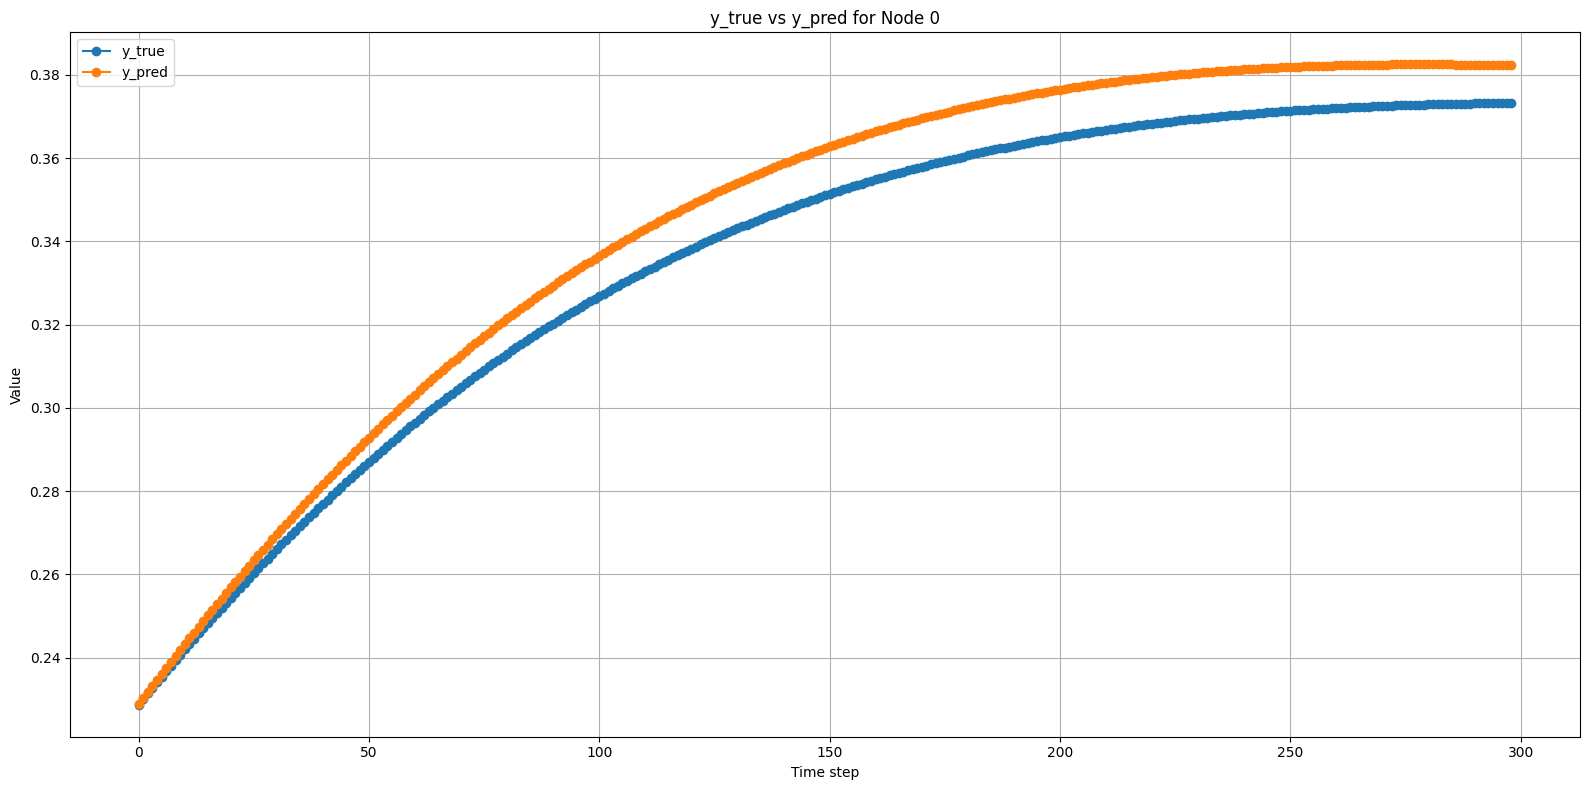

In [33]:
plot_predictions(y_true, y_pred, node_index=0)

In [10]:
model_path_gkan = "./saved_models/gkan/model_biochemical_gkan/biochemical_gkan_ic5_s5/0/gkan"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

hierarchical_symb_fitting(
    model_path=model_path_gkan,
    theta=-np.inf,
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    pysr_model=pysr_model,    
    sample_size=9000,
    message_passing=False,
    include_time=False,
    neuron_level=True
)

### Population GKAN

#### IC=1

In [35]:
model_path_gkan = "./saved_models/gkan/model_population_gkan/population_gkan_ic1_s5_dopri/0/gkan"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [36]:
gkan_symb

\sum_{j}( 0.1985902*x_j**2) - 0.46224803*x_i**2

In [37]:
quantise(gkan_symb)

\sum_{j}(0.2*x_j**2) - 0.46*x_i**2

In [77]:
g_symb = lambda x: 0.1985902 * torch.square(x[:, 1].unsqueeze(-1))
h_symb = lambda x: x[:, 1].unsqueeze(-1) - 0.46224803 * torch.square(x[:, 0].unsqueeze(-1))

y_true, y_pred = post_process_gkan(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/gkan/model_population_gkan/population_gkan_ic1_s5_dopri/0',
    test_set=POP,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.012868192978203297
Number of model's parameters: 168
Test loss best model: 0.005176595412194729


In [12]:
model_path_gkan = "./saved_models/gkan/model_population_gkan/population_gkan_ic1_s5_dopri/0/gkan"


get_error_spline_wise(
    model_path=model_path_gkan,
    test_set=POP,
    theta=0.1
)

Pruning node (0,2)


/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_

Pruning node (0,2)


/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')


Test error: 0.25065886974334717


/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')


\sum_{j}(-0.03*x_i + 0.37*x_j - 0.16) - 0.72*x_i + 0.32

#### IC=3

In [45]:
model_path_gkan = "./saved_models/gkan/model_population_gkan/population_gkan_ic3_s5/0/gkan"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [46]:
gkan_symb

\sum_{j}( 0.199048513992728*x_j**2) - 0.469166671319236*x_i**2

In [47]:
quantise(gkan_symb)

\sum_{j}(0.2*x_j**2) - 0.47*x_i**2

In [48]:
g_symb = lambda x: 0.199048513992728 * torch.square(x[:, 1].unsqueeze(-1))
h_symb = lambda x:  x[:, 1].unsqueeze(-1) - 0.469166671319236 * torch.square(x[:, 0].unsqueeze(-1))

y_true, y_pred = post_process_gkan(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/gkan/model_population_gkan/population_gkan_ic3_s5/0',
    test_set=POP,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.011239863932132721
Number of model's parameters: 134
Test loss best model: 0.0010535747278481722


In [13]:
model_path_gkan = "./saved_models/gkan/model_population_gkan/population_gkan_ic3_s5/0/gkan"

get_error_spline_wise(
    model_path=model_path_gkan,
    test_set=POP,
    theta=0.1
)

/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_

Test error: 0.046312835067510605


\sum_{j}(0.39*x_j - 0.01*(x_i - 0.51)**3 - 0.14) - 0.74*x_i + 0.22

#### IC=5

In [12]:
model_path_gkan = "./saved_models/gkan/model_population_gkan/population_gkan_ic5_s5/1/gkan"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

In [13]:
gkan_symb

\sum_{j}( 0.198871001145202*x_j**2) - 0.4876688*x_i**2

In [14]:
quantise(gkan_symb)

\sum_{j}(0.2*x_j**2) - 0.49*x_i**2

In [87]:
g_symb = lambda x: 0.198871001145202 * torch.square(x[:, 1].unsqueeze(-1))
h_symb = lambda x:  x[:, 1].unsqueeze(-1) - 0.48766035 * torch.square(x[:, 0].unsqueeze(-1))

y_true, y_pred = post_process_gkan(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/gkan/model_population_gkan/population_gkan_ic5_s5/1',
    test_set=POP,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.001696695457212627
Number of model's parameters: 143
Test loss best model: 0.0009939937153831124


In [13]:
model_path_gkan = "./saved_models/gkan/model_population_gkan/population_gkan_ic5_s5/1/gkan"

splie_wise, error, y_true, y_pred = get_error_spline_wise(
    model_path=model_path_gkan,
    test_set=POP,
    theta=0.1,
    atol=1e-4,
    rtol=1e-3
)

Pruning node (0,1)


In [14]:
splie_wise

\sum_{j}(0.07*exp(-0.31*x_i**2 + 0.05*x_i + 0.79*x_j) + 0.69*tanh(0.1*x_i + 0.6*x_j - 1.47) + 0.57) - 0.61*tan(0.58*x_i + 0.26) + 0.23

In [15]:
print(f"Test error: {error}")

Test error: 0.22230073809623718


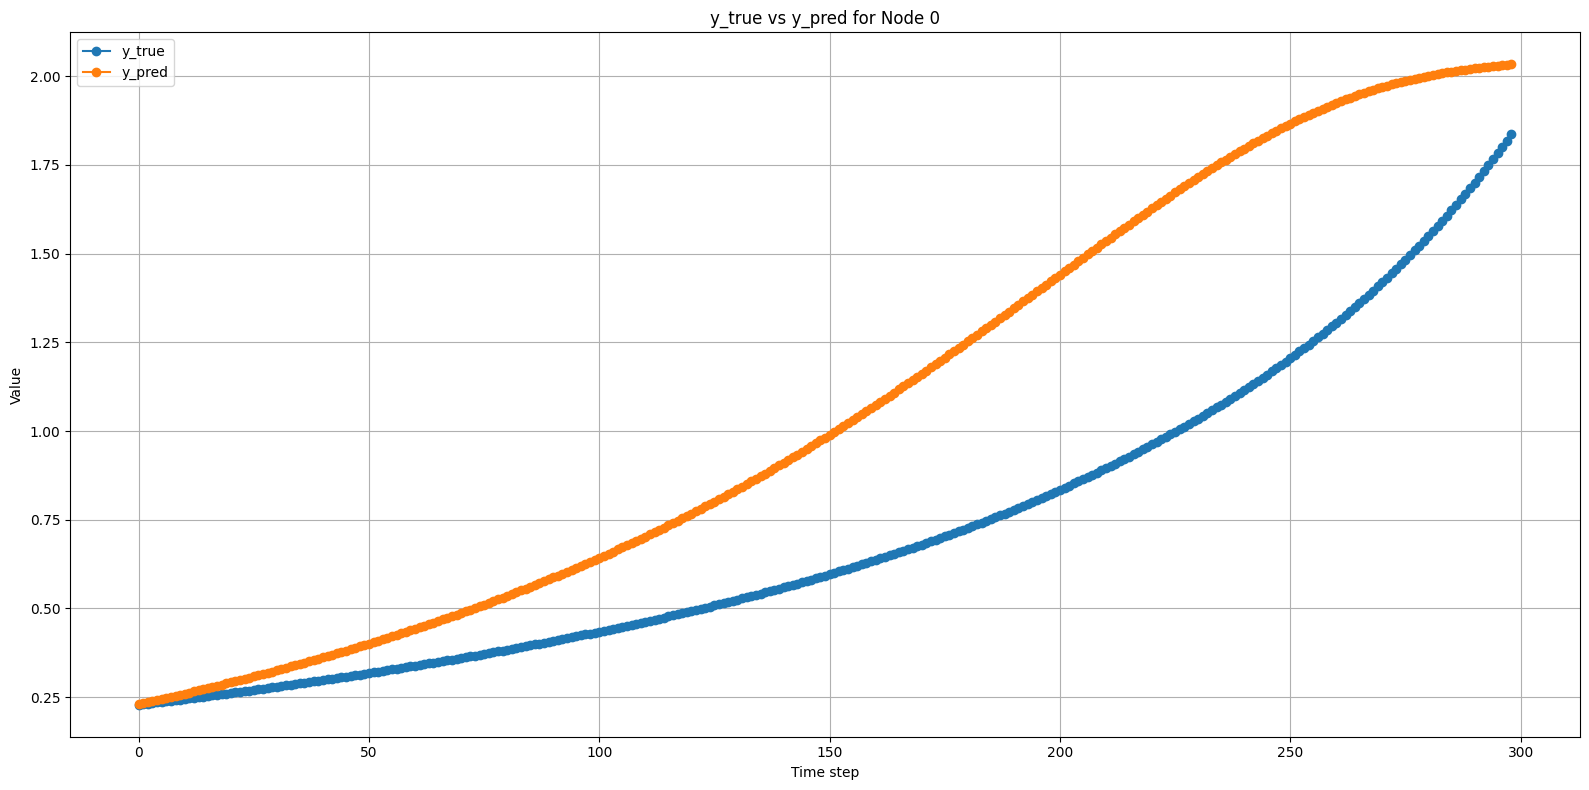

In [16]:
plot_predictions(y_true, y_pred, node_index=0)

In [11]:
model_path_gkan = "./saved_models/gkan/model_population_gkan/population_gkan_ic5_s5/1/gkan"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

hierarchical_symb_fitting(
    model_path=model_path_gkan,
    theta=-np.inf,
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    pysr_model=pysr_model,    
    sample_size=10000,
    message_passing=False,
    include_time=False,
    neuron_level=True
)

## Symb Reg Pred deriv

### Biochemical Pred Deriv


#### IC=1

In [59]:
model_path_gkan = "./saved_models/gkan/model_biochemical_gkan/biochemical_gkan_ic1_s5_pd_seed/0/gkan"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [60]:
gkan_symb

\sum_{j}( -0.49973878*x_i*x_j) + log(2.6240933 - x_i)

In [65]:
g_symb = lambda x: (-0.49973878*x[:, 1] * x[:, 0]).unsqueeze(-1)
h_symb = lambda x: x[:, 1].unsqueeze(-1) + torch.log(2.6240933 - x[:, 0].unsqueeze(-1))

y_true, y_pred = post_process_gkan(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/gkan/model_biochemical_gkan/biochemical_gkan_ic1_s5_pd_seed/0',
    test_set=BIO,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.0013994744513183832
Number of model's parameters: 356
Test loss best model: 0.0002516376553103328


#### IC=3


In [61]:
model_path_gkan = "./saved_models/gkan/model_biochemical_gkan/biochemical_gkan_ic3_s5_pd_seed/0/gkan"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [62]:
gkan_symb

\sum_{j}( -0.49980658*x_i*x_j) - 0.49943864*x_i + 0.99958766

In [66]:
g_symb = lambda x: (-0.49980658*x[:, 1] * x[:, 0]).unsqueeze(-1)
h_symb = lambda x: -0.49943864 * x[:, 0].unsqueeze(-1) + 0.99958766 + x[:, 1].unsqueeze(-1)

y_true, y_pred = post_process_gkan(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/gkan/model_biochemical_gkan/biochemical_gkan_ic3_s5_pd_seed/0',
    test_set=BIO,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 5.818752833874896e-05
Number of model's parameters: 360
Test loss best model: 0.00011091509077232331


#### IC=5

In [67]:
model_path_gkan = "./saved_models/gkan/model_biochemical_gkan/biochemical_gkan_ic5_s5_pd_seed/0/gkan"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [68]:
gkan_symb

\sum_{j}( -0.49984205*x_i*x_j) - 0.49919242*x_i + 0.9994993

In [69]:
g_symb = lambda x: (-0.49984205*x[:, 1] * x[:, 0]).unsqueeze(-1)
h_symb = lambda x: -0.49919242 * x[:, 0].unsqueeze(-1) + 0.9994993 + x[:, 1].unsqueeze(-1)

y_true, y_pred = post_process_gkan(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/gkan/model_biochemical_gkan/biochemical_gkan_ic5_s5_pd_seed/0',
    test_set=BIO,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 6.530150130856782e-05
Number of model's parameters: 231
Test loss best model: 6.882120214868337e-05


In [16]:
model_path_gkan = "./saved_models/gkan/model_biochemical_gkan/biochemical_gkan_ic5_s5_pd_seed/0/gkan"

spline_wise, error = get_error_spline_wise(
    model_path=model_path_gkan,
    test_set=BIO,
    theta=0.1
)

Pruning node (0,0)


In [17]:
spline_wise

\sum_{j}(-0.12*x_i - 0.12*x_j + 1.34*cos(0.35*x_i + 0.35*x_j - 0.08) - 1.28) - 0.5*x_i + 1.0

In [18]:
print(f"Test error: {error}")

Test error: 0.014207941479980946


### Neuronal Pred Deriv

#### IC=1

In [70]:
model_path_gkan = "./saved_models/gkan/model_neuronal_gkan/neuronal_gkan_ic1_s5_pd_seed/0/gkan"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [71]:
gkan_symb

\sum_{j}( 0.29748031*tanh(x_j)) - 0.07849252*x_i**2 + 0.1580574

In [72]:
g_symb = lambda x: 0.29748031 * torch.tanh(x[:, 1].unsqueeze(-1))
h_symb = lambda x: x[:, 1].unsqueeze(-1) - 0.07849252 * torch.square(x[:, 0].unsqueeze(-1)) + 0.1580574

y_true, y_pred = post_process_gkan(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/gkan/model_neuronal_gkan/neuronal_gkan_ic1_s5_pd_seed/0',
    test_set=NEUR,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.012120253406465054
Number of model's parameters: 382
Test loss best model: 0.0017284597270190716


In [85]:
quantise(symb_spline_wise)

\sum_{j}(0.12 - 0.18*tanh(-0.52*x_j + 0.19*tanh(1.08*x_i - 5.37) + 0.2)) - 0.47*sin(1.2*sin(0.36*x_i - 1.0) - 0.15) + 0.49*sin(1.23*sin(0.38*x_i - 1.03) + 3.0) - 0.86

#### IC=3


In [ ]:
model_path_gkan = "./saved_models/gkan/model_neuronal_gkan/neuronal_gkan_ic3_s5_pd_seed/0/gkan"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [78]:
gkan_symb

\sum_{j}( 0.29548913*tanh(x_j)) - log(x_i + 1) + tanh(x_i)

In [75]:
quantise(gkan_symb)

\sum_{j}(0.3*tanh(x_j)) - log(x_i + 1) + tanh(x_i)

In [79]:
g_symb = lambda x: 0.29548913 * torch.tanh(x[:, 1].unsqueeze(-1))
h_symb = lambda x: x[:, 1].unsqueeze(-1) - torch.log(x[:, 0].unsqueeze(-1) + 1) + torch.tanh(x[:, 0].unsqueeze(-1))

y_true, y_pred = post_process_gkan(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/gkan/model_neuronal_gkan/neuronal_gkan_ic3_s5_pd_seed/0',
    test_set=NEUR,
    message_passing=False,
    include_time=False,
    method='dopri5',
)

Test loss of symbolic formula: 0.03424684703350067
Number of model's parameters: 179
Test loss best model: 0.0005534670781344175


In [82]:
quantise(symb_spline_wise)

\sum_{j}(0.8 - 1.07*tanh(-4.65*(0.01*x_j + 1)**3 + 0.03*Abs(0.9*x_i - 0.16) + 5.59)) - 0.18*sin(6.26*tanh(0.26*x_i - 0.8) + 1.82) - 0.3*tanh(6.26*Abs(0.17*x_i - 0.11) - 2.08) - 0.35

#### IC=5

In [86]:
model_path_gkan = "./saved_models/gkan/model_neuronal_gkan/neuronal_gkan_ic5_s5_pd_seed/0/gkan"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [87]:
gkan_symb

\sum_{j}( 0.30008048*tanh(x_j)) - 0.08635484*x_i**2 + 0.162708174692492

In [88]:
g_symb = lambda x: 0.30008048 * torch.tanh(x[:, 1].unsqueeze(-1))
h_symb = lambda x: x[:, 1].unsqueeze(-1) - 0.08635484 * torch.square(x[:, 0].unsqueeze(-1)) + 0.162708174692492

y_true, y_pred = post_process_gkan(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/gkan/model_neuronal_gkan/neuronal_gkan_ic5_s5_pd_seed/0',
    test_set=NEUR,
    message_passing=False,
    include_time=False,
    method='dopri5',
)

Test loss of symbolic formula: 0.013893825933337212
Number of model's parameters: 153
Test loss best model: 0.0005195835838094354


In [19]:
model_path_gkan = "./saved_models/gkan/model_neuronal_gkan/neuronal_gkan_ic5_s5_pd_seed/0/gkan"

spline_wise, error = get_error_spline_wise(
    model_path=model_path_gkan,
    test_set=NEUR,
    theta=-np.inf
)

In [20]:
spline_wise

\sum_{j}(0.21*tanh(0.06*x_j**3 - 0.43*x_j**2 + 1.64*x_j - 0.48) + 0.09) - 0.58*sin(0.46*x_i - 1.18) - 0.3*sin(0.55*x_i - 2.13) + 4.7*cos(0.08*x_i - 0.04) - 5.3

In [21]:
print(f"Test Error: {error}")

Test Error: 0.019371381029486656


#### IC=20

In [30]:
model_path_gkan = "./saved_models/gkan/model_neuronal_gkan/neuronal_gkan_ic20_s5_pd_seed/0/gkan"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [31]:
gkan_symb

\sum_{j}( 0.29994336*tanh(x_j)) - 0.085054725*x_i**2 + 0.16075952

### Kuramoto Pred deriv

#### IC=1

In [58]:
model_path_gkan = "./saved_models/gkan/model_kuramoto_gkan/kuramoto_gkan_ic1_s5_pd_seed/0/gkan"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [59]:
gkan_symb

\sum_{j}( -0.49865502*sin(x_i - x_j)) - 0.000115402737525952*x_i**3 + 2.0085964

In [53]:
quantise(gkan_symb)

\sum_{j}(-0.5*sin(x_i - x_j)) + 2.0

In [60]:
g_symb = lambda x: -0.49865514* torch.sin(x[:, 0] - x[:, 1]).unsqueeze(-1)
h_symb = lambda x: x[:, 1].unsqueeze(-1) + 2.0085964 - 0.000115402737525952 * torch.pow(x[:, 0].unsqueeze(-1), 3)

y_true, y_pred = post_process_gkan(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/gkan/model_kuramoto_gkan/kuramoto_gkan_ic1_s5_pd_seed/0',
    test_set=KUR,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.0072832792066037655
Number of model's parameters: 256
Test loss best model: 0.011241629719734192


In [18]:
model_path_gkan = "./saved_models/gkan/model_kuramoto_gkan/kuramoto_gkan_ic1_s5_pd_seed/0/gkan"

get_error_spline_wise(
    model_path=model_path_gkan,
    test_set=KUR,
    theta=0.05,
    alpha=0.09
)

Pruning node (0,2)


/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_policy='omit')
/extra/rcappi/Kan-for-Graph-Dyn/utils/utils.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func_optim, x, y, p0=[1., 0., 1., 0.], nan_

Test error: 0.47489508986473083


\sum_{j}(-0.01*(0.55*x_i - 1)**2 - 0.16*(0.18*x_i - 0.24*x_j + 1)**2 - 0.5*sin(-1.02*x_i + 1.02*x_j + 3.02) + 0.05*tanh(0.98*x_j - 1.51) + 0.18) - 0.06*((1 - 0.2*x_i)**2 - 0.43)**2 - 0.28*sin(0.1*x_i - 1.9) + 1.73

#### IC=3

In [107]:
model_path_gkan = "./saved_models/gkan/model_kuramoto_gkan/kuramoto_gkan_ic3_s5_pd_seed/0/gkan"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [108]:
gkan_symb

\sum_{j}( -0.50034684*sin(x_i - x_j)) + 0.0025323885*sin(x_i) + 2.0002553

In [111]:
quantise(gkan_symb)

\sum_{j}(-0.5*sin(x_i - x_j)) + 2.0

In [110]:
g_symb = lambda x: -0.50034684* torch.sin(x[:, 0] - x[:, 1]).unsqueeze(-1)
h_symb = lambda x: x[:, 1].unsqueeze(-1) - 0.0025323885 * torch.sin(x[:, 0].unsqueeze(-1)) + 2.0002553

y_true, y_pred = post_process_gkan(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/gkan/model_kuramoto_gkan/kuramoto_gkan_ic3_s5_pd_seed/0',
    test_set=KUR,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.001366805867291987
Number of model's parameters: 234
Test loss best model: 0.0044190287590026855


In [40]:
model_path_gkan = "./saved_models/gkan/model_kuramoto_gkan/kuramoto_gkan_ic3_s5_pd_seed/0/gkan"

spline_wise, error = get_error_spline_wise(
    model_path=model_path_gkan,
    test_set=KUR,
    theta=0.1,
    alpha=1e-4
)

Pruning node (0,0)
Pruning node (0,1)
Pruning node (0,2)


In [41]:
spline_wise

\sum_{j}(0.29*sin(8.15*sin(0.07*x_i + 3.15) + 3.97*tanh(0.16*x_j + 0.02) - 0.41) + 0.12) + 2.01

#### IC=5

In [56]:
model_path_gkan = "./saved_models/gkan/model_kuramoto_gkan/kuramoto_gkan_ic5_s5_pd_seed/0/gkan"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [57]:
gkan_symb

\sum_{j}( -0.50092536*sin(x_i - x_j)) - 0.00050581875*x_i + 2.0022514

In [ ]:
g_symb = lambda x: -0.50092536* torch.sin(x[:, 0].unsqueeze(-1) - x[:, 1].unsqueeze(-1))
h_symb = lambda x: x[:, 1].unsqueeze(-1) - 0.00050581875 * x[:, 0].unsqueeze(-1) + 2.0022514

y_true, y_pred = post_process_gkan(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/gkan/model_kuramoto_gkan/kuramoto_gkan_ic5_s5_pd_seed/0',
    test_set=KUR,
    message_passing=False,
    include_time=False,
    method='dopri5',
    pred_deriv=True
)

Test loss of symbolic formula: 0.0011962071293964982
Number of model's parameters: 137
Test loss best model: 0.0030159619636833668


In [16]:
model_path_gkan = "./saved_models/gkan/model_kuramoto_gkan/kuramoto_gkan_ic5_s5_pd_seed/0/gkan"

splie_wise, error, y_true, y_pred = get_error_spline_wise(
    model_path=model_path_gkan,
    test_set=KUR,
    theta=0.05
)

Pruning node (0,0)
Pruning node (0,1)
Pruning node (0,2)
Pruning node (0,0)
Pruning node (0,3)
Pruning node (0,4)


In [17]:
splie_wise

\sum_{j}(-0.49*sin(1.0*x_i - 1.0*x_j + 0.01)) + 0.94*tanh(0.12*x_i - 0.26) + 1.59

In [9]:
print(f"Test error: {error}")

Test error: 0.18454454839229584


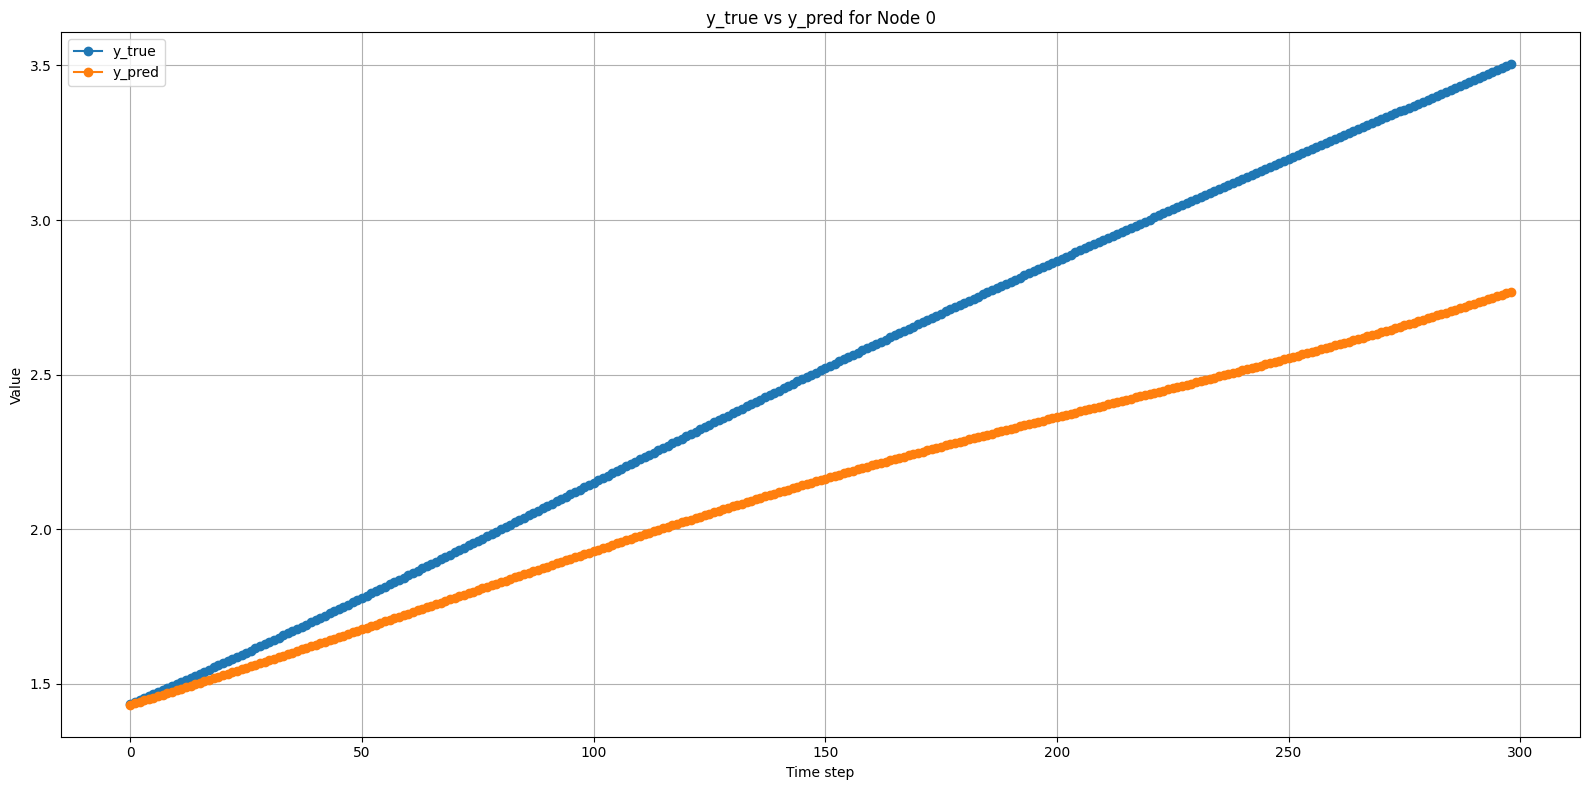

In [11]:
plot_predictions(y_true, y_pred, node_index=0)

### Epidemics Pred Deriv

#### IC=1

In [16]:
model_path_gkan = "./saved_models/gkan/model_epidemics_gkan/epidemics_gkan_ic1_s5_pd_seed/0/gkan"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [17]:
gkan_symb

\sum_{j}( x_j*exp(-3*x_i)) - 0.4993961*x_i

In [18]:
quantise(gkan_symb)

\sum_{j}(x_j*exp(-3*x_i)) - 0.5*x_i

In [19]:
g_symb = lambda x: x[:, 1].unsqueeze(-1) * torch.exp(-3 * x[:, 0].unsqueeze(-1))
h_symb = lambda x: x[:, 1].unsqueeze(-1) - 0.4993961 * x[:, 0].unsqueeze(-1)

y_true, y_pred = post_process_gkan(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/gkan/model_epidemics_gkan/epidemics_gkan_ic1_s5_pd_seed/0',
    test_set=EPID,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.019961263984441757
Number of model's parameters: 156
Test loss best model: 0.0003966010990552604


#### IC=3

In [64]:
model_path_gkan = "./saved_models/gkan/model_epidemics_gkan/epidemics_gkan_ic3_s5_pd_seed/0/gkan"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [65]:
gkan_symb

\sum_{j}( 0.499918288355768*x_j*(1.0001105 - x_i)) - 0.50024692188064*x_i

In [66]:
g_symb = lambda x: 0.499918288355768*x[:, 1].unsqueeze(-1) * (-x[:, 0].unsqueeze(-1) + 1.0001105)
h_symb = lambda x: x[:, 1].unsqueeze(-1) - 0.50024692188064 * x[:, 0].unsqueeze(-1)

y_true, y_pred = post_process_gkan(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/gkan/model_epidemics_gkan/epidemics_gkan_ic3_s5_pd_seed/0',
    test_set=EPID,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 6.118987948866561e-05
Number of model's parameters: 256
Test loss best model: 0.0008446515421383083


#### IC=5

In [25]:
model_path_gkan = "./saved_models/gkan/model_epidemics_gkan/epidemics_gkan_ic5_s5_pd_seed/0/gkan"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [26]:
gkan_symb

\sum_{j}( x_j*(0.4999851 - 0.4999413*x_i)) - 0.5002681*x_i

In [27]:
g_symb = lambda x: x[:, 1].unsqueeze(-1) * (0.4999851 - 0.4999413*x[:, 0].unsqueeze(-1))
h_symb = lambda x: x[:, 1].unsqueeze(-1) - 0.5002681 * x[:, 0].unsqueeze(-1)

y_true, y_pred = post_process_gkan(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/gkan/model_epidemics_gkan/epidemics_gkan_ic5_s5_pd_seed/0',
    test_set=EPID,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 6.544290954479948e-05
Number of model's parameters: 410
Test loss best model: 0.00042536036926321685


In [28]:
model_path_gkan = "./saved_models/gkan/model_epidemics_gkan/epidemics_gkan_ic5_s5_pd_seed/0/gkan"

spline_wise, error = get_error_spline_wise(
    model_path=model_path_gkan,
    test_set=EPID,
    theta=0.01
)

In [29]:
spline_wise

\sum_{j}(0.02*x_i + 0.17*x_j + 0.29*(0.73*x_j - tan(0.64*x_i + 0.2) + 0.34)**2 - 0.18*tan(0.64*x_i + 0.2) - 0.1*tan(0.75*x_i + 0.1) + 0.18) - 0.5*x_i

In [30]:
latex(spline_wise)

'\\sum_{j}(0.02*x_i + 0.17*x_j + 0.29*(0.73*x_j - tan(0.64*x_i + 0.2) + 0.34)**2 - 0.18*tan(0.64*x_i + 0.2) - 0.1*tan(0.75*x_i + 0.1) + 0.18) - 0.5 x_{i}'

In [31]:
print(f"Test error: {error}")

Test error: 0.005680431611835957


In [23]:
model_path_gkan = "./saved_models/gkan/model_epidemics_gkan/epidemics_gkan_ic5_s5_pd_seed/0/gkan"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

hg, hh = hierarchical_symb_fitting(
    model_path=model_path_gkan,
    theta=0.1,
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    pysr_model=pysr_model,    
    sample_size=10000,
    message_passing=False,
    include_time=False
)

Pruning node (0,0)
Pruning node (0,4)


In [24]:
hg

defaultdict(dict,
            {'f_0': {'neuron_1_0': '-0.0623134736022801*x_i**3 + x_j**2*log(1.9884525 - x_i)**2 + 0.07103184*tanh(x_j*exp(x_i))'},
             'f_1': {'neuron_0_0': '0.30109268*exp(x_i) - 0.70027965*log(x_j + 1) - 0.293644824',
              'neuron_0_1': '-log(0.46514988*x_j + 1) - 0.172465*sin(x_i) + 0.067584656',
              'neuron_0_2': '0.39687215448841*x_i**2 + 0.050895363*x_j**3',
              'neuron_1_0': '-0.0906980467403685*x_i**2 - 0.0116312267314204*x_j**3 + (-(-log(0.46514988*x_j + 1) - 0.172465*sin(x_i) + 0.067584656)**3 - 0.23215072)*(-log(0.46514988*x_j + 1) - 0.172465*sin(x_i) + 0.067584656) + 0.343411249750527*(-0.429960630728024*exp(x_i) + log(x_j + 1) + 0.775826177442112)**3 + 0.03152645'}})

In [25]:
hh

defaultdict(dict,
            {'f_0': {'neuron_1_0': '-0.044609215*x_i + 0.27445534*log(1 - 0.3870558*x_i) + log(log(1 - 0.18001223*x_i) + 1) - 0.19012554*log(log(tanh(x_i) + 1) + 1) - 0.033717435*sin(x_i) + 0.0083225986'},
             'f_1': {'neuron_0_0': 'log(x_i + 1)',
              'neuron_0_1': '-0.704028918128618*x_i',
              'neuron_0_2': '-0.10234226*x_i',
              'neuron_0_3': '0.39230493*x_i',
              'neuron_0_4': '0.17309737*x_i',
              'neuron_1_0': '-0.166596215669702*x_i - 0.24884525*log(x_i + 1) - 0.084115215*tanh(1.97863509837746*x_i) - 0.284314213 + 0.2728908*exp(-0.10234226*x_i)'}})

### Population Pred Deriv

In [ ]:
config_path = './configs/config_ic5/config_population.yml'
config = load_config(config_path)

exp = ExperimentsGKAN(
    config=config,
    n_trials=1,
    study_name='test-population',
    process_id=0,
)

best_model = build_model_from_file(
    model_path="./saved_models/gkan/model_population_gkan/population_gkan_ic5_s5_pd_seed/0",
    message_passing=False,
    include_time=False,
    method='dopri5',
    adjoint=True,
    pred_deriv=False
)

#### IC=1

In [24]:
model_path_gkan = "./saved_models/gkan/model_population_gkan/population_gkan_ic1_s5_pd_seed/0/gkan"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

In [25]:
gkan_symb

\sum_{j}( 0.19899322*x_j**2) - 0.47013423*x_i**2

In [26]:
quantise(gkan_symb)

\sum_{j}(0.2*x_j**2) - 0.47*x_i**2

In [78]:
g_symb = lambda x: 0.19899322 * torch.square(x[:, 1].unsqueeze(-1))
h_symb = lambda x: x[:, 1].unsqueeze(-1) - 0.4701342 * torch.square(x[:, 0].unsqueeze(-1))

y_true, y_pred = post_process_gkan(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/gkan/model_population_gkan/population_gkan_ic1_s5_pd_seed/0',
    test_set=POP,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.010538171045482159
Number of model's parameters: 244
Test loss best model: 0.0034099107142537832


#### IC=3

In [79]:
best_model = build_model_from_file(
    model_path="./saved_models/gkan/model_population_gkan/population_gkan_ic3_s5_pd_seed/0",
    message_passing=False,
    include_time=False,
    method='dopri5',
    adjoint=True,
    pred_deriv=False
)

exp.post_processing(best_model, raw_data=exp.training_set.raw_data_sampled[1])

In [80]:
model_path_gkan = "./saved_models/gkan/model_population_gkan/population_gkan_ic3_s5_pd_seed/0/gkan"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [81]:
gkan_symb

\sum_{j}( 0.20091663*x_j**2) - 0.4844201*x_i**2

In [82]:
g_symb = lambda x: 0.20091663 * torch.square(x[:, 1].unsqueeze(-1))
h_symb = lambda x: x[:, 1].unsqueeze(-1) - 0.4844201 * torch.square(x[:, 0].unsqueeze(-1))

y_true, y_pred = post_process_gkan(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/gkan/model_population_gkan/population_gkan_ic3_s5_pd_seed/0',
    test_set=POP,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.011106949299573898
Number of model's parameters: 228
Test loss best model: 0.001501783961430192


#### IC=5

In [83]:
best_model = build_model_from_file(
    model_path="./saved_models/gkan/model_population_gkan/population_gkan_ic5_s5_pd_seed/0",
    message_passing=False,
    include_time=False,
    method='dopri5',
    adjoint=True)

exp.post_processing(best_model, raw_data=exp.training_set.raw_data_sampled[1][:240])

In [84]:
model_path_gkan = "./saved_models/gkan/model_population_gkan/population_gkan_ic5_s5_pd_seed/0/gkan"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [85]:
gkan_symb

\sum_{j}( 0.199565682620062*x_j**2) - 0.49878263*x_i**2

In [86]:
g_symb = lambda x: 0.199565682620062 * torch.square(x[:, 1].unsqueeze(-1))
h_symb = lambda x: x[:, 1].unsqueeze(-1) - 0.49878263 * torch.square(x[:, 0].unsqueeze(-1))

y_true, y_pred = post_process_gkan(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/gkan/model_population_gkan/population_gkan_ic5_s5_pd_seed/0',
    test_set=POP,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.0010785746853798628
Number of model's parameters: 284
Test loss best model: 0.0017615474062040448


In [32]:
model_path_gkan = "./saved_models/gkan/model_population_gkan/population_gkan_ic5_s5_pd_seed/0/gkan"

spline_wise, error = get_error_spline_wise(
    model_path=model_path_gkan,
    test_set=EPID,
    theta=0.01
)

Pruning node (0,0)
Pruning node (0,2)


In [33]:
spline_wise

\sum_{j}(0.87 - 0.89*cos(0.86*sin(0.85*x_j - 1.07) + 0.9)) - 0.46*exp(0.54*x_i) + 0.82*sin(3.19*cos(0.49*x_i + 0.09) - 1.86) - 0.28

In [34]:
print(f"Test Error: {error}")

Test Error: 0.13897493481636047


In [7]:
# spline = pd.read_csv("./saved_models/gkan/model_population_gkan/population_gkan_ic5_s5_pd_seed/0/gkan/h_net/1_0_1.csv")
# x = spline['x']
# y = spline['y']
# func_1_0_0 = lambda x: -0.417440921841148*x - 0.0206961179118608
# y_hat = func_1_0_0(x)

# spline_2 = pd.read_csv("./saved_models/gkan/model_population_gkan/population_gkan_ic5_s5_pd_seed/0/gkan/h_net/0_1_0.csv")
# x_2 = spline_2['x']
# y_2 = spline_2['y']
# func_0_1_0 = lambda x: 0.864792293598356*x - 0.129660943750775
# y_hat_2 = func_0_1_0(x_2)

spline_100 = pd.read_csv("./saved_models/gkan/model_population_gkan/population_gkan_ic5_s5_pd_seed/0/gkan/h_net/1_0_0.csv")
x_100 = spline_100['x']
y_100 = spline_100['y']
func_1_0_0 = lambda x: -0.13961735367775*x**2 + 0.191250771284103*x + 0.0247471053153276
y_hat_100 = func_1_0_0(x_100)



# 0.287263571827889*x0 + 0.0299829353485954

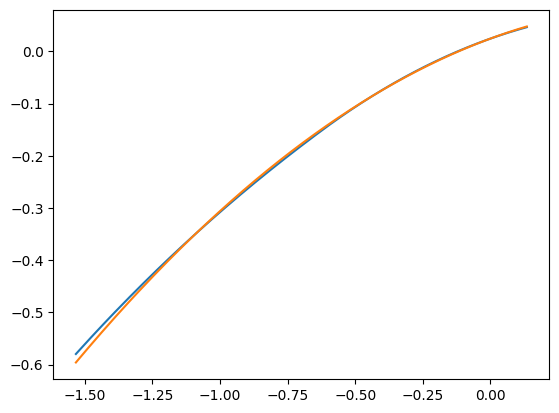

In [8]:
# plt.plot(x, y)
# plt.plot(x, y_hat)
# plt.plot(x_2, y_2)
# plt.plot(x_2, y_hat_2)
plt.plot(x_100, y_100)
plt.plot(x_100, y_hat_100)
# plt.plot(x_100, y_hat_parab)

In [9]:
spline_101 = pd.read_csv("./saved_models/gkan/model_population_gkan/population_gkan_ic5_s5_pd_seed/0/gkan/h_net/1_0_1.csv")
x_101 = spline_101['x']
y_101 = spline_101['y']
func_1_0_1 = lambda x: -0.142224431037903*x**2 - 0.294323205947876*x - 0.0382768586277962
y_hat_101 = func_1_0_1(x_101)


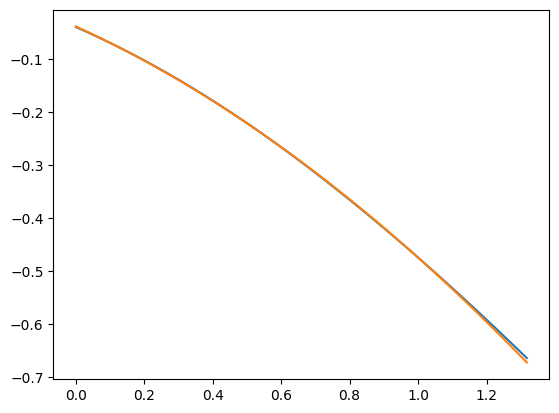

In [10]:
plt.plot(x_101, y_101)
plt.plot(x_101, y_hat_101)

In [15]:
new_x = np.arange(-5, 5, 0.02)

In [16]:
func_000 = lambda x: -0.520608007907867*x**2 - 0.247195333242416*x + 0.14544615149498
func_010 = lambda x: 0.86479240655899*x - 0.129660904407501

kan = func_1_0_0(func_000(new_x)) + func_1_0_1(func_010(new_x))

In [17]:
model_path = "./saved_models/gkan/model_population_gkan/population_gkan_ic5_s5_pd_seed/0/gkan/h_net"

cache_acts, cache_preacts = get_kan_arch(n_layers=2, model_path=model_path)
pruned_acts, pruned_preacts = pruning(cache_acts, cache_preacts, theta=-np.inf)

input = pruned_preacts[0]
output = pruned_acts[-1].sum(dim=2)

in_dim = input.size(1)
out_dim = output.size(1)

x = input.detach().numpy().reshape(-1, in_dim)
y = output.detach().numpy().reshape(-1, out_dim)


func_symb = lambda x: (
    -0.1 * x**2
    - 0.3 * x
    - 0.11 * (x - 0.15)**2
    - 0.04 * (-x**2 - 0.47 * x + 0.28)**2
    + 0.05
)


y_symb_ugly = func_symb(new_x)

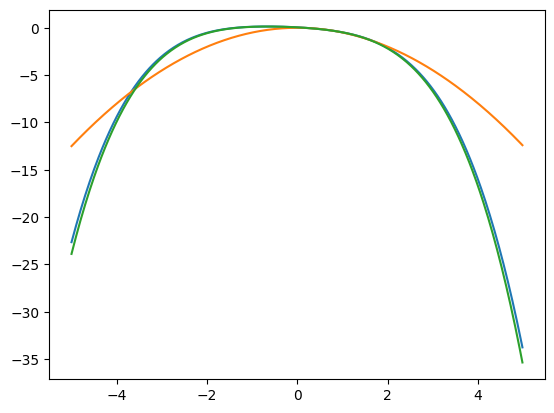

In [18]:
plt.plot(new_x, kan)
plt.plot(new_x, -0.5*new_x**2)
# plt.scatter(x, y)
plt.plot(new_x, y_symb_ugly)

### Spline to csv

In [10]:

def spline_to_csv(acts, preacts, n_layers = 2, output_dir='./saved_models'):
    os.makedirs(output_dir, exist_ok=True)
    for l in range(n_layers):
        in_dim = acts[l].shape[2]
        out_dim = acts[l].shape[1]
        for j in range(out_dim):
            for i in range(in_dim):
                x = preacts[l][:, i].reshape(-1)
                y = acts[l][:, j, i].reshape(-1)
                
                # Sort by x
                sort_idx = np.argsort(x)
                x_sorted = x[sort_idx]
                y_sorted = y[sort_idx]

                df = pd.DataFrame({'x': x_sorted, 'y': y_sorted})
                filename = f'{l}_{j}_{i}.csv'
                filepath = os.path.join(output_dir, filename)
                df.to_csv(filepath, index=False)

In [ ]:
acts_g, preacts_g = get_kan_arch(
    n_layers=2,
    model_path="./saved_models/gkan/model_epidemics_gkan/epidemics_gkan_ic5_s5_pd_seed/0/gkan/g_net"
)

acts_g_pruned, preacts_g_pruned = pruning(acts_g, preacts_g, theta=0.1)

acts_h, preacts_h = get_kan_arch(
    n_layers=2,
    model_path="./saved_models/gkan/model_epidemics_gkan/epidemics_gkan_ic5_s5_pd_seed/0/gkan/h_net"
)

acts_h_pruned, preacts_h_pruned = pruning(acts_h, preacts_h, theta=0.1)
                
# g_net
spline_to_csv(
    acts_g_pruned, 
    preacts_g_pruned, 
    n_layers=2, 
    output_dir="./saved_models/gkan/model_epidemics_gkan/epidemics_gkan_ic5_s5_pd_seed/0/gkan/g_net/spline_to_csv"
)

# h_net
spline_to_csv(
    acts_h_pruned, 
    preacts_h_pruned, 
    n_layers=2, 
    output_dir="./saved_models/gkan/model_epidemics_gkan/epidemics_gkan_ic5_s5_pd_seed/0/gkan/h_net/spline_to_csv"
)
    

Pruning node (0,0)
Pruning node (0,4)
Pruning node (0,1)


In [11]:
acts_h, preacts_h = get_kan_arch(
    n_layers=2,
    model_path="./saved_models/gkan/model_population_gkan/population_gkan_ic5_s5_pd_seed/0/gkan/h_net"
)

acts_h_pruned, preacts_h_pruned = pruning(acts_h, preacts_h, theta=0.1)

spline_to_csv(
    acts_h_pruned, 
    preacts_h_pruned, 
    n_layers=2, 
    output_dir="./saved_models/gkan/model_population_gkan/population_gkan_ic5_s5_pd_seed/0/gkan/h_net"
)

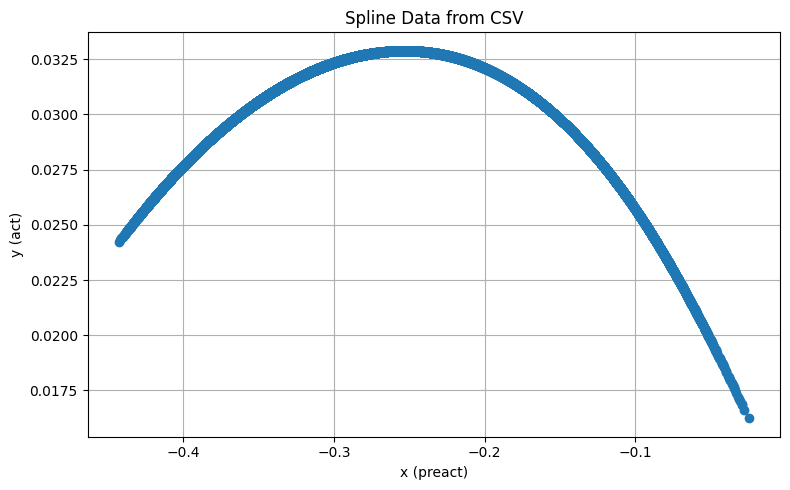

In [6]:
df = pd.read_csv("./saved_models/gkan/model_epidemics_gkan/epidemics_gkan_ic5_s5_pd_seed/0/gkan/g_net/spline_to_csv/1_0_0.csv")

# Plot the data
plt.figure(figsize=(8, 5))
plt.plot(df['x'], df['y'], marker='o', linestyle='-')
plt.title('Spline Data from CSV')
plt.xlabel('x (preact)')
plt.ylabel('y (act)')
plt.grid(True)
plt.tight_layout()
plt.show()